In [1]:
!pip install geopandas
!pip install rioxarray

import numpy as np
import matplotlib.pyplot as plt
from math import *
import cv2
import geopandas as gpd
from google.colab import drive
import os
import pickle
import rioxarray
from pyproj import CRS
import fiona
import pandas as pd
from matplotlib.collections import PatchCollection
import matplotlib

drive.mount("/content/drive")
os.chdir('/content/drive/MyDrive/DREAMS - Zhiang/Projects/Rock Traits/data')
print(os.listdir())
mm = 0.0393701  # 1 mm = 0.0393701 inch

     |████████████████████████████████| 1.0 MB 3.8 MB/s 
     |████████████████████████████████| 16.7 MB 39.3 MB/s 
     |████████████████████████████████| 6.3 MB 30.3 MB/s 
     |████████████████████████████████| 47 kB 109 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=68d5dc4bcce5e6fbfaab01491514b344681befb939b3308aec7d1b1dcacf5535
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray
Mounted at /content/drive
['README', 'C3_sk.jpg', 'registered_instances_c3_rgbd1.pickle', 'registered_instances_c3_rgbd1_refined.pickle', 'registered_instances_c3_rgbd1_refined_update.pickle', 'c3_rocks', 'registered_instances_c3_rgbd1_update.pickle', 'registered_instances_c3_rgbd1_update_0.pi

In [2]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

# read shapefile

In [3]:
# open a tif raster and read attributes 
c3 = rioxarray.open_rasterio("C3.tif")

In [ ]:
# attributes
print(c3.rio.crs)
print(c3.rio.nodata)
print(c3.rio.bounds())
print(c3.rio.width)
print(c3.rio.height)
print(c3.rio.resolution())

EPSG:32611
None
(372333.78378156334, 4145784.960907128, 372544.162856863, 4146294.8455599267)
10589
25664
(0.019867699999973145, -0.019867699999960856)


In [4]:
epsg = c3.rio.crs.to_epsg()
crs = CRS(epsg)
crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
c3_rock_shape = gpd.read_file("c3_rocks/all_v1/rockPoly_all_v1.shp")
print(c3_rock_shape.shape)
#c3_rock_shape.plot()
#c3_rock_shape

(237945, 7)


In [6]:
areas = c3_rock_shape.area
areas = areas[areas>0.000313]
areas = areas.to_numpy()
areas = areas[areas>0]
D_mm = np.sqrt(areas * 10**6/pi)*2
phi = -np.log2(D_mm)



In [ ]:
np.median(phi)

-6.216320709160337

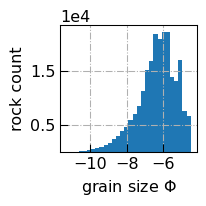

In [7]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})



size = (2.15, 2.15)
dpi = 96

fig = plt.figure(figsize = size, dpi=dpi)
plt.ylabel('rock count')
plt.xlabel('grain size $\Phi$')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xticks(np.arange(-10, 1, 2.0))
plt.yticks(np.arange(5000, 30000, 10000))

fig.tight_layout()
plt.gca().hist(phi[phi<5], bins=30)
plt.gca().tick_params(direction="in", length=6)
plt.gca().grid(linestyle='-.')
set_size(fig, size, dpi=dpi)
#plt.savefig('paper_figures/rock_size_entire_area.svg', format='svg', bbox_inches='tight')
plt.show()

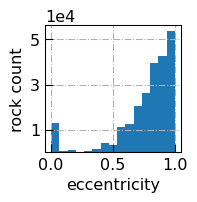

In [8]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})

size = (2.05, 2.10)
dpi=96

areas = c3_rock_shape.area
ecc = c3_rock_shape.eccentrici[areas>0.000313].to_numpy()


#ecc = c3_rock_shape.eccentrici.to_numpy()
fig = plt.figure(figsize = size, dpi=dpi)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ylabel('rock count')
plt.xlabel('eccentricity')
plt.xticks(np.arange(0, 1.1, 0.5))
plt.yticks(np.arange(10000, 100001, 20000))
plt.hist(ecc, bins=15)
plt.tick_params(direction="in", length=6)
plt.grid(linestyle='-.')

set_size(fig, size = size, dpi=96)
plt.show()

In [9]:
print(ecc[ecc>0.5].shape)
print(ecc[ecc<=0.5].shape)
(210421-27524)/210421.

(207383,)
(22927,)


0.869195565081432

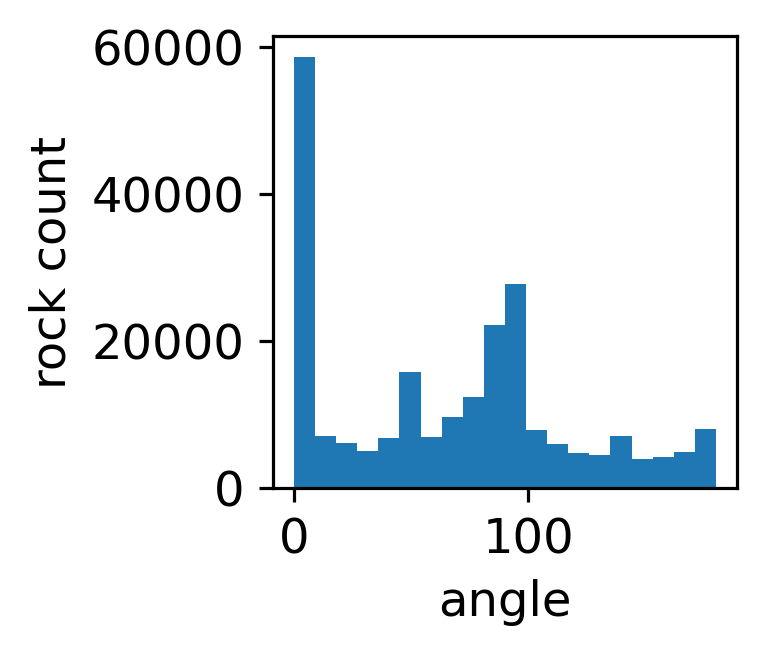

In [10]:
plt.figure(figsize = (2.08, 2.08), dpi=96*3)
areas = c3_rock_shape.area
angle = c3_rock_shape.angle[areas>0.000313].to_numpy()
#angle = c3_rock_shape.angle.to_numpy()
plt.ylabel('rock count')
plt.xlabel('angle')
plt.hist(angle, bins=20)
plt.show()

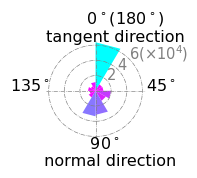

In [11]:
plt.rcParams.update({'font.size': 12})
nm, ang = np.histogram(angle, bins=12)
fig, ax = plt.subplots(figsize=(1.55, 1.55), dpi=96)
lim = np.max(nm) + 20
plt.xlim(-lim-10000,lim+10000)
plt.ylim(-lim-10000,lim+10000)
y0 = x0 = 0

#image = np.zeros((y0,y0,3), dtype='uint8')
#c = np.array([np.cos(np.deg2rad(x)) for x in range(0,95,10)])
#s = np.array([np.sin(np.deg2rad(x)) for x in range(0,95,10)])


circle1 = plt.Circle((0, 0), 20000, color='gray', fill=False, linestyle='-.', linewidth=0.5)
circle2 = plt.Circle((0, 0), 40000, color='gray', fill=False, linestyle='-.', linewidth=0.5)
circle3 = plt.Circle((0, 0), 60000, color='gray', fill=False, linestyle='-.', linewidth=0.5)
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
#ax.add_patch(circle4)
#ax.add_patch(circle5)
ax.text(14800, 14800, '2', fontsize=11, color='gray')
ax.text(28500, 28500, '4', fontsize=11, color='gray')
ax.text(42500, 42500, r'$6(\times 10^4)$', fontsize=11, color='gray')
#ax.text(27940, 27940, '4e4', fontsize=12, color='gray')
#ax.text(35240, 35240, '5e4', fontsize=12, color='gray')

ax.text(-70000, 65000, '         $0^\circ (180^\circ )$ \n tangent direction')
ax.text(64000, 1000, '$45^\circ$')
ax.text(-72000, -98000, '          $90^\circ$ \n normal direction')
ax.text(-110000, 1000, '$135^\circ$')
plt.plot((-lim, lim), (0,0), color='gray', linestyle='-.', linewidth=0.5)
plt.plot((-0, 0), (-lim,lim+1000), color='gray', linestyle='-.', linewidth=0.5)

patches = []
colors = []

for i in range(nm.shape[0]):
    angle1 = ang[i+1]*2
    angle2 = ang[i]*2
    r = nm[i]
    y1 = r*np.cos(np.deg2rad(angle1))
    x1 = r*np.sin(np.deg2rad(angle1))
    y2 = r*np.cos(np.deg2rad(angle2))
    x2 = r*np.sin(np.deg2rad(angle2))
    pts = np.array(((x0,y0),(x1,y1),(x2,y2)))
    poly = plt.Polygon(pts, zorder=0)
    patches.append(poly)
    colors.append(1 - r/lim)

p = PatchCollection(patches, cmap=matplotlib.cm.cool, alpha=1)
p.set_array(np.array(colors))
ax.add_collection(p)

plt.axis('OFF')

plt.show()

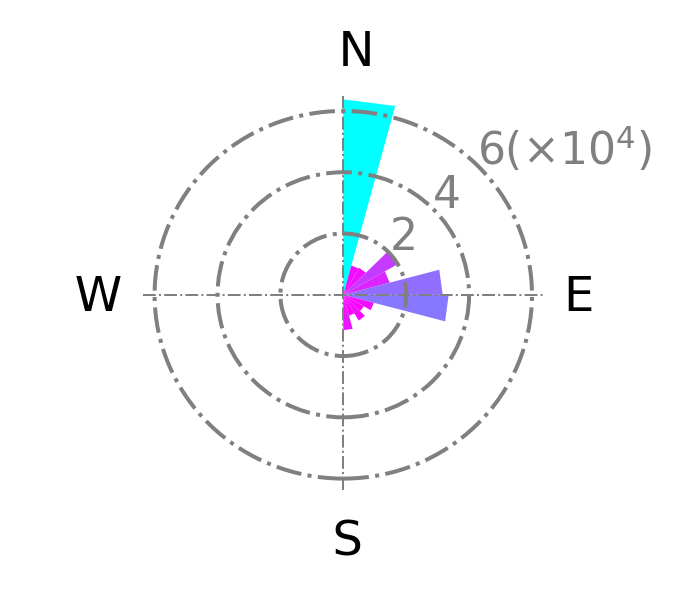

In [12]:
plt.rcParams.update({'font.size': 12})
nm, ang = np.histogram(angle, bins=12)
fig, ax = plt.subplots(figsize=(2.08, 2.08), dpi=96*3)
lim = np.max(nm) + 20
plt.xlim(-lim-10000,lim+10000)
plt.ylim(-lim-10000,lim+10000)
y0 = x0 = 0

#image = np.zeros((y0,y0,3), dtype='uint8')
#c = np.array([np.cos(np.deg2rad(x)) for x in range(0,95,10)])
#s = np.array([np.sin(np.deg2rad(x)) for x in range(0,95,10)])


circle1 = plt.Circle((0, 0), 20000, color='gray', fill=False, linestyle='-.')
circle2 = plt.Circle((0, 0), 40000, color='gray', fill=False, linestyle='-.')
circle3 = plt.Circle((0, 0), 60000, color='gray', fill=False, linestyle='-.')
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
#ax.add_patch(circle4)
#ax.add_patch(circle5)
ax.text(14800, 14800, '2', fontsize=11, color='gray')
ax.text(28500, 28500, '4', fontsize=11, color='gray')
ax.text(42500, 42500, r'$6(\times 10^4)$', fontsize=11, color='gray')
#ax.text(27940, 27940, '4e4', fontsize=12, color='gray')
#ax.text(35240, 35240, '5e4', fontsize=12, color='gray')

ax.text(-50000, 75000,  '          N')
ax.text(70000, -5000, 'E')
ax.text(-52000, -85000, '          S')
ax.text(-100000, -5000, '   W')
plt.plot((-lim, lim), (0,0), color='gray', linestyle='-.', linewidth=0.5)
plt.plot((-0, 0), (-lim,lim+1000), color='gray', linestyle='-.', linewidth=0.5)

patches = []
colors = []

for i in range(nm.shape[0]):
    angle1 = ang[i+1]
    angle2 = ang[i]
    r = nm[i]
    y1 = r*np.cos(np.deg2rad(angle1))
    x1 = r*np.sin(np.deg2rad(angle1))
    y2 = r*np.cos(np.deg2rad(angle2))
    x2 = r*np.sin(np.deg2rad(angle2))
    pts = np.array(((x0,y0),(x1,y1),(x2,y2)))
    poly = plt.Polygon(pts, zorder=0)
    patches.append(poly)
    colors.append(1 - r/lim)

p = PatchCollection(patches, cmap=matplotlib.cm.cool, alpha=1)
p.set_array(np.array(colors))
ax.add_collection(p)

plt.axis('OFF')

plt.show()

# slice shapefile with mesh grid

In [13]:
longitude0, latitude0, longitude1, latitude1 = c3.rio.bounds()
step = 5  # step size of the mesh grids (meters)
nm_long = int((longitude1 - longitude0)/step)  # cell numbers along longitude
nm_lat = int((latitude1 - latitude0)/step)  # cell numbers along altitude
print("cell numbers on longitude and latitude: ", nm_long, nm_lat)

cell numbers on longitude and latitude:  42 101


In [ ]:
# only run this cell at first time
""" # comment for safety
size = 0
for idx_x in range(33, nm_long):
  for idx_y in range(nm_lat):
    x0 = longitude0 + step*idx_x
    x1 = longitude0 + step*idx_x + step 
    y0 = latitude0 + step*idx_y
    y1 = latitude0 + step*idx_y + step
    box_shape = c3_rock_shape.cx[x0:x1, y0:y1]
    file_name = 'c3_rocks/all_v1/sliced_shapefile/' + str(idx_x) + "_" + str(idx_y) + ".shp"
    if box_shape.size != 0:
      box_shape.to_file(file_name)
      size = size + box_shape.size
      print(idx_x, idx_y, size)

"""

# read sliced shapefiles

In [ ]:
# only run this cell at first time
shapefiles = [f for f in os.listdir('c3_rocks/all_v1/sliced_shapefile/') if f.endswith('.shp')]

shape_dict = {}

for shapefile in shapefiles:
  f = os.path.join('c3_rocks/all_v1/sliced_shapefile/', shapefile)
  rock_shp = gpd.read_file(f)
  coords = tuple([int(i) for i in shapefile.split('.')[0].split('_')])
  shape_dict[coords] = rock_shp

In [ ]:
# only run this cell at first time
with open('c3_rocks/all_v1/sliced_shapefile_dict.pickle', 'wb') as handle:
    pickle.dump(shape_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('c3_rocks/all_v1/sliced_shapefile_dict.pickle', 'rb') as handle:
    shape_dict = pickle.load(handle)

# obtain rock trait statistics

In [15]:
# percentile filter for overall
areas = c3_rock_shape.area
c3_rock_shape = c3_rock_shape[areas>0.000313]
median_A_mm_sqr = c3_rock_shape.area.median() * 10**6  # median of area in mm sqare
median_D_mm = sqrt(median_A_mm_sqr/pi)*2
phi_50 = -log(median_D_mm, 2)
print("phi_50: ", phi_50)

def Phi_bounds(lower, upper):
  """
  params: lower and upper arguments are in percentage
  return: phi_lower, phi_upper, A_lower, A_upper
  """
  A_list = np.sort(c3_rock_shape.area.to_numpy())  # areas of rocks
  N = A_list.shape[0]  # number of rocks
  idx_lower = int(lower/100.0 * N)
  idx_upper = int(upper/100.0 * N)
  A_lower = A_list[idx_lower]
  A_upper = A_list[idx_upper]
  D_lower_mm = sqrt(A_lower * 10**6/pi)*2
  D_upper_mm = sqrt(A_upper * 10**6/pi)*2
  phi_lower = -log(D_lower_mm, 2)
  phi_upper = -log(D_upper_mm, 2)
  return phi_lower, phi_upper, A_lower, A_upper

print(Phi_bounds(5,95))
# according to Tyler's thesis, for rocks on the fault scarp, Phi_50 = -8.77

phi_50:  -6.216320709160338
(-4.779086150202267, -8.391890714877663, 0.0005920882567149301, 0.08861587546820106)


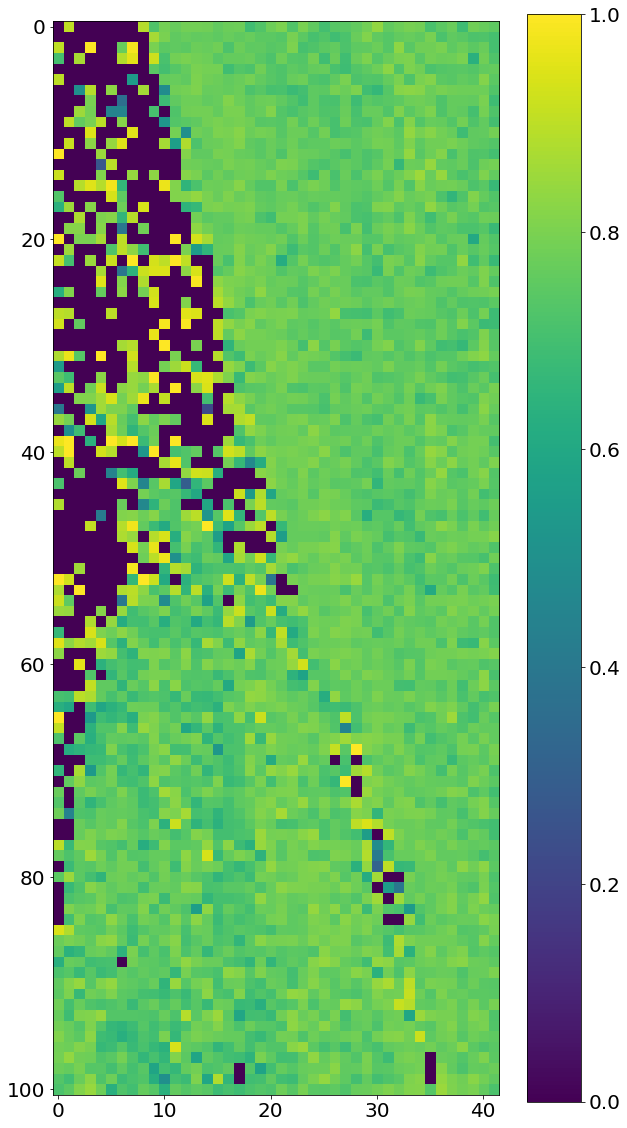

<Figure size 1800x1200 with 0 Axes>

In [16]:
plt.rcParams.update({'font.size': 20})
mean_ecc_map = np.zeros((nm_long, nm_lat))

def get_eccentricity(shp_dict):
  mean_ecc_map = np.zeros((nm_long, nm_lat))
  for k in shp_dict.keys():
    shp = shape_dict[k]
    eccs = shp.eccentrici
    eccs.mean()
    eccs.median()
    eccs.std()
    mean_ecc_map[k[0], k[1]] = eccs.mean()
  return mean_ecc_map

mean_ecc_map = get_eccentricity(shape_dict)
plt.figure(figsize = (10,20))
plt.imshow(np.flipud(mean_ecc_map.transpose()))
plt.colorbar()
plt.figure(dpi=300)
plt.show()

In [ ]:
shape_dict[(0, 0)]

,name,size,major_leng,minor_leng,eccentrici,angle,geometry
0,rock,61,13.381925,6.581609,0.87,108.229095,"POLYGON ((372338.810 4145785.160, 372338.830 4..."
1,rock,63,10.477818,8.006548,0.65,13.746284,"POLYGON ((372334.936 4145785.775, 372334.956 4..."
2,rock,18,5.701950,4.590849,0.59,5.364200,"POLYGON ((372335.810 4145785.199, 372335.830 4..."
3,rock,46,11.700199,5.625466,0.88,164.439178,"POLYGON ((372334.618 4145785.656, 372334.638 4..."
4,rock,4,2.581989,2.581989,0.00,0.000000,"POLYGON ((372335.373 4145785.080, 372335.393 4..."
...,...,...,...,...,...,...,...
93,rock,7,3.859428,3.189530,0.56,38.221405,"POLYGON ((372335.095 4145788.299, 372335.115 4..."
94,rock,3,2.828427,1.632993,0.82,135.000000,"POLYGON ((372338.413 4145788.736, 372338.433 4..."
95,rock,17,7.469100,3.435413,0.89,92.197556,"POLYGON ((372336.406 4145789.173, 372336.426 4..."
96,rock,21,7.552083,3.939453,0.85,20.232782,"POLYGON ((372333.843 4145789.908, 372333.863 4..."


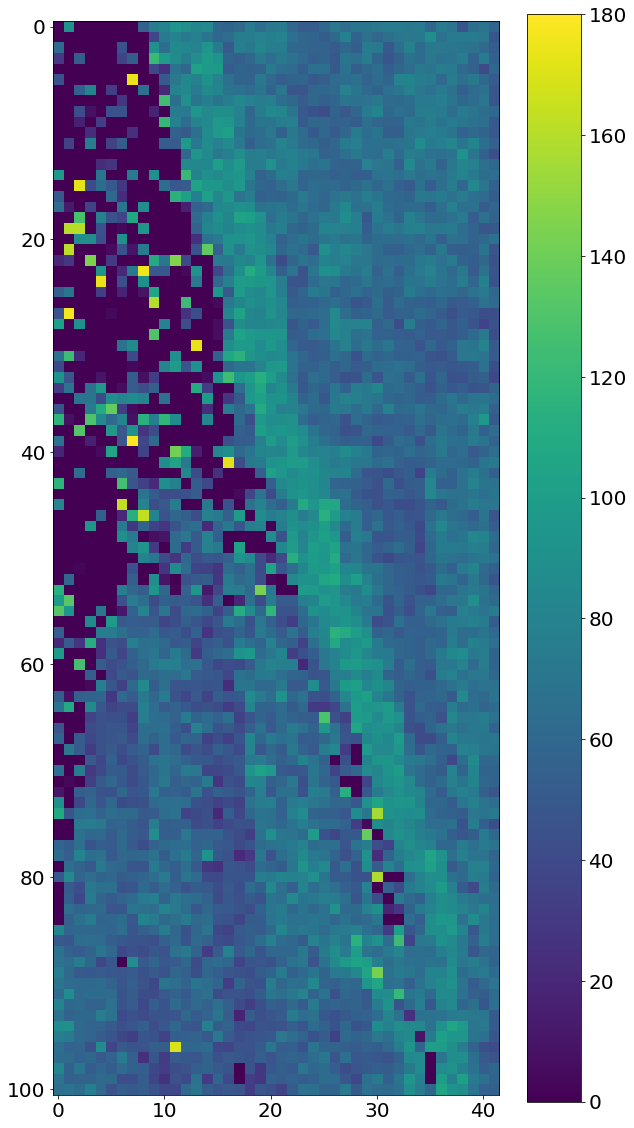

<Figure size 1800x1200 with 0 Axes>

In [ ]:
"""
^  0 degree
|
|
|
O -------> 90 degree
|
|
|
V   180 degree
"""

def get_orientation(shp_dict):
  mean_ori_map = np.zeros((nm_long, nm_lat))
  for k in shp_dict.keys():
    shp = shape_dict[k]
    angle = shp.angle
    angle.mean()
    angle.median()
    angle.std()
    mean_ori_map[k[0], k[1]] = angle.mean()
  return mean_ori_map

mean_ori_map = get_orientation(shape_dict)
plt.figure(figsize = (10,20))
plt.imshow(np.flipud(mean_ori_map.transpose()))
plt.colorbar()
plt.figure(dpi=300)
plt.show()

In [ ]:
shape_dict[(38,78)]

,name,size,major_leng,minor_leng,eccentrici,angle,geometry
0,rock,9,6.512371,2.277154,0.94,88.111816,"POLYGON ((372528.785 4146178.858, 372528.805 4..."
1,rock,30,10.073166,4.275897,0.91,0.456181,"POLYGON ((372528.110 4146178.957, 372528.130 4..."
2,rock,10,6.992377,2.292069,0.94,0.000000,"POLYGON ((372528.110 4146178.957, 372528.130 4..."
3,rock,18,9.277068,2.827452,0.95,111.829689,"POLYGON ((372527.832 4146179.891, 372527.851 4..."
4,rock,9,6.512371,2.277154,0.94,88.111816,"POLYGON ((372527.871 4146179.613, 372527.891 4..."
5,rock,6,4.901645,2.228641,0.89,82.768814,"POLYGON ((372528.805 4146179.196, 372528.825 4..."
6,rock,8,3.782712,3.378576,0.45,45.000000,"POLYGON ((372527.752 4146179.335, 372527.772 4..."
7,rock,10,7.378512,2.167962,0.96,96.108803,"POLYGON ((372527.812 4146179.891, 372527.832 4..."
8,rock,0,2.746899,0.000000,1.00,0.000000,"POLYGON ((372528.765 4146179.176, 372528.785 4..."
9,rock,2,1.000000,0.000000,1.00,0.000000,"POLYGON ((372527.891 4146179.633, 372527.911 4..."


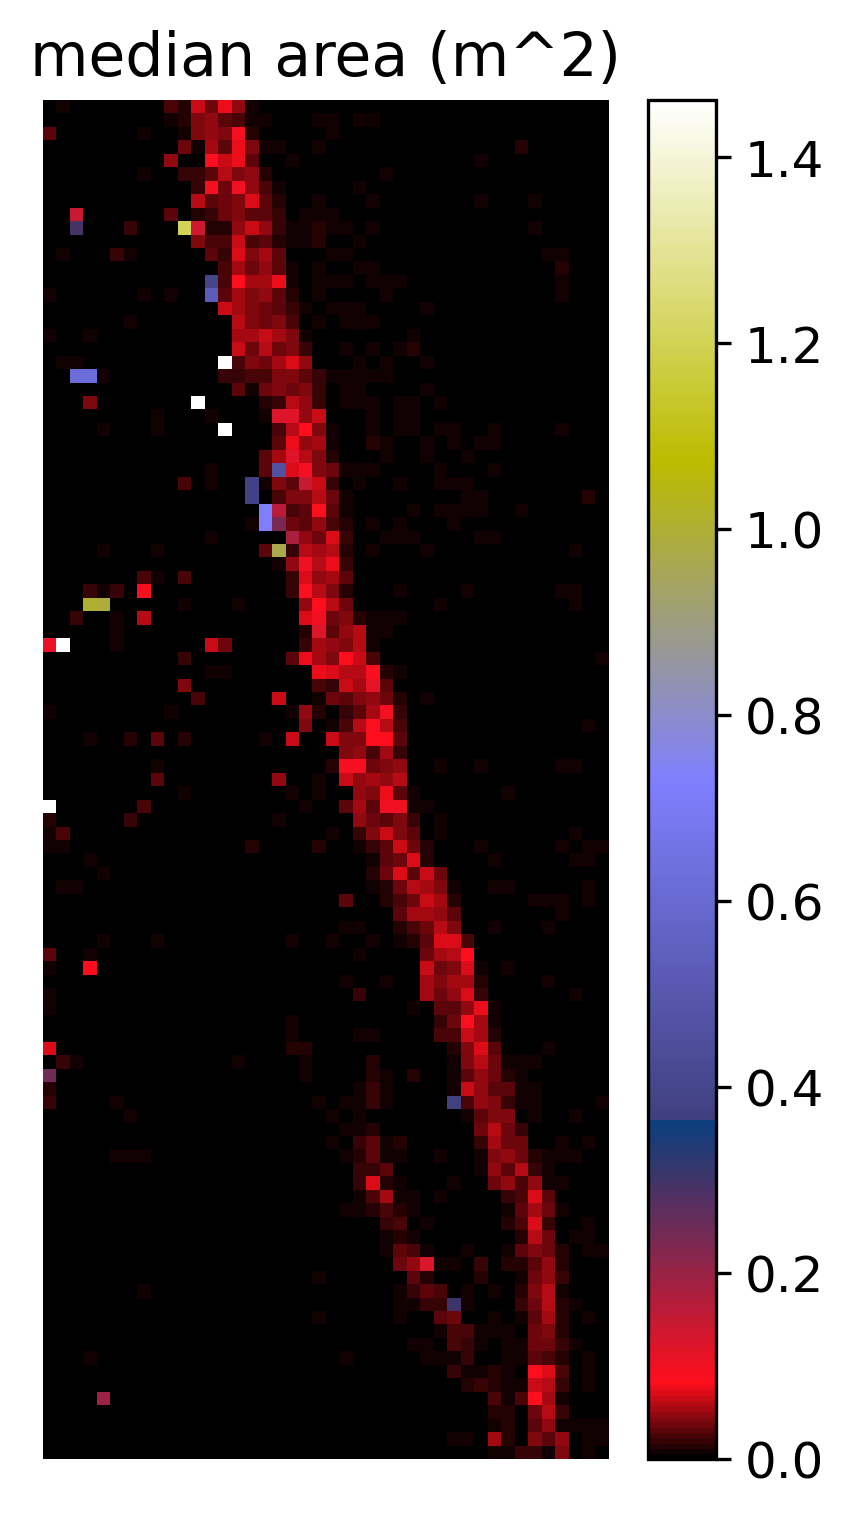

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})

def get_area(shp_dict):
  mean_area_map = np.zeros((nm_long, nm_lat))
  for k in shp_dict.keys():
    shp = shape_dict[k]
    areas = shp.area
    areas = areas[areas>0.000314]
    mean_area_map[k[0], k[1]] = areas.median()
  return mean_area_map

mean_area_map = get_area(shape_dict)
plt.figure(figsize = (3.4,6), dpi=300)
plt.imshow(np.flipud(mean_area_map.transpose()), cmap='gist_stern')  # cmap: gnuplot, terrain, gist_ncar
plt.colorbar()
plt.title('median area (m^2)')
plt.axis('OFF')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


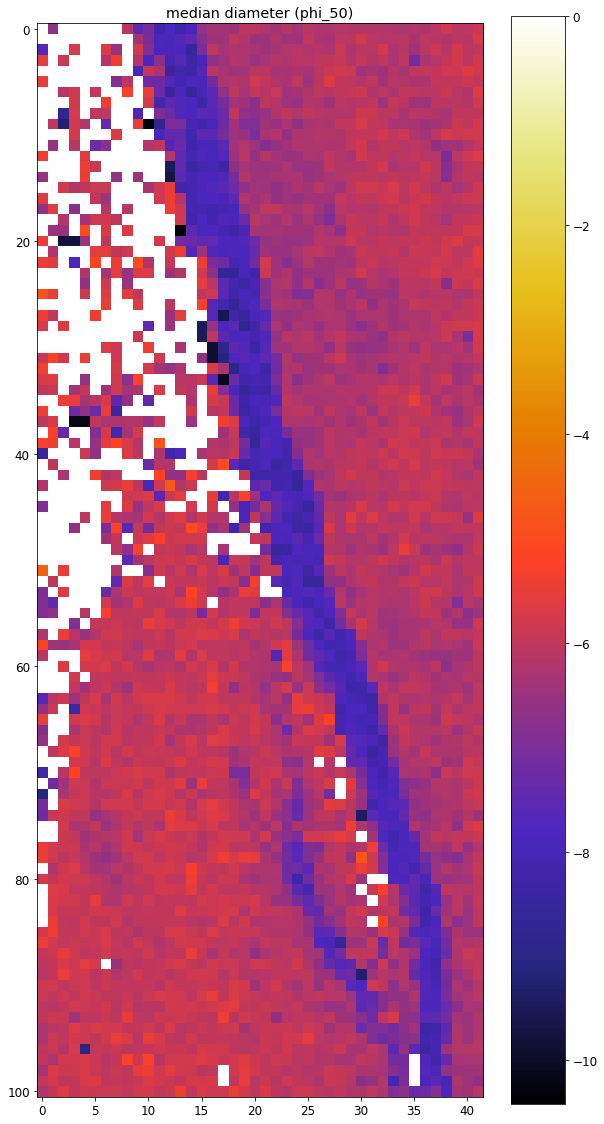

<Figure size 1800x1200 with 0 Axes>

In [ ]:
def get_area_phi(shp_dict):
  mean_area_map = np.zeros((nm_long, nm_lat))
  for k in shp_dict.keys():
    shp = shape_dict[k]
    areas = shp.area
    areas = areas[areas>0.000314]
    areas = np.median(areas.to_numpy())
    D_mm = np.sqrt(areas * 10**6/pi)*2
    phi = -np.log2(D_mm)
    mean_area_map[k[0], k[1]] = phi
  return mean_area_map

mean_area_map = get_area_phi(shape_dict)
plt.figure(figsize = (10,20))
plt.imshow(np.flipud(mean_area_map.transpose()), cmap='CMRmap')  # cmap: gnuplot, terrain, gist_ncar, CMRmap
plt.colorbar()
plt.title('median diameter (phi_50)')
plt.figure(dpi=300)
plt.show()

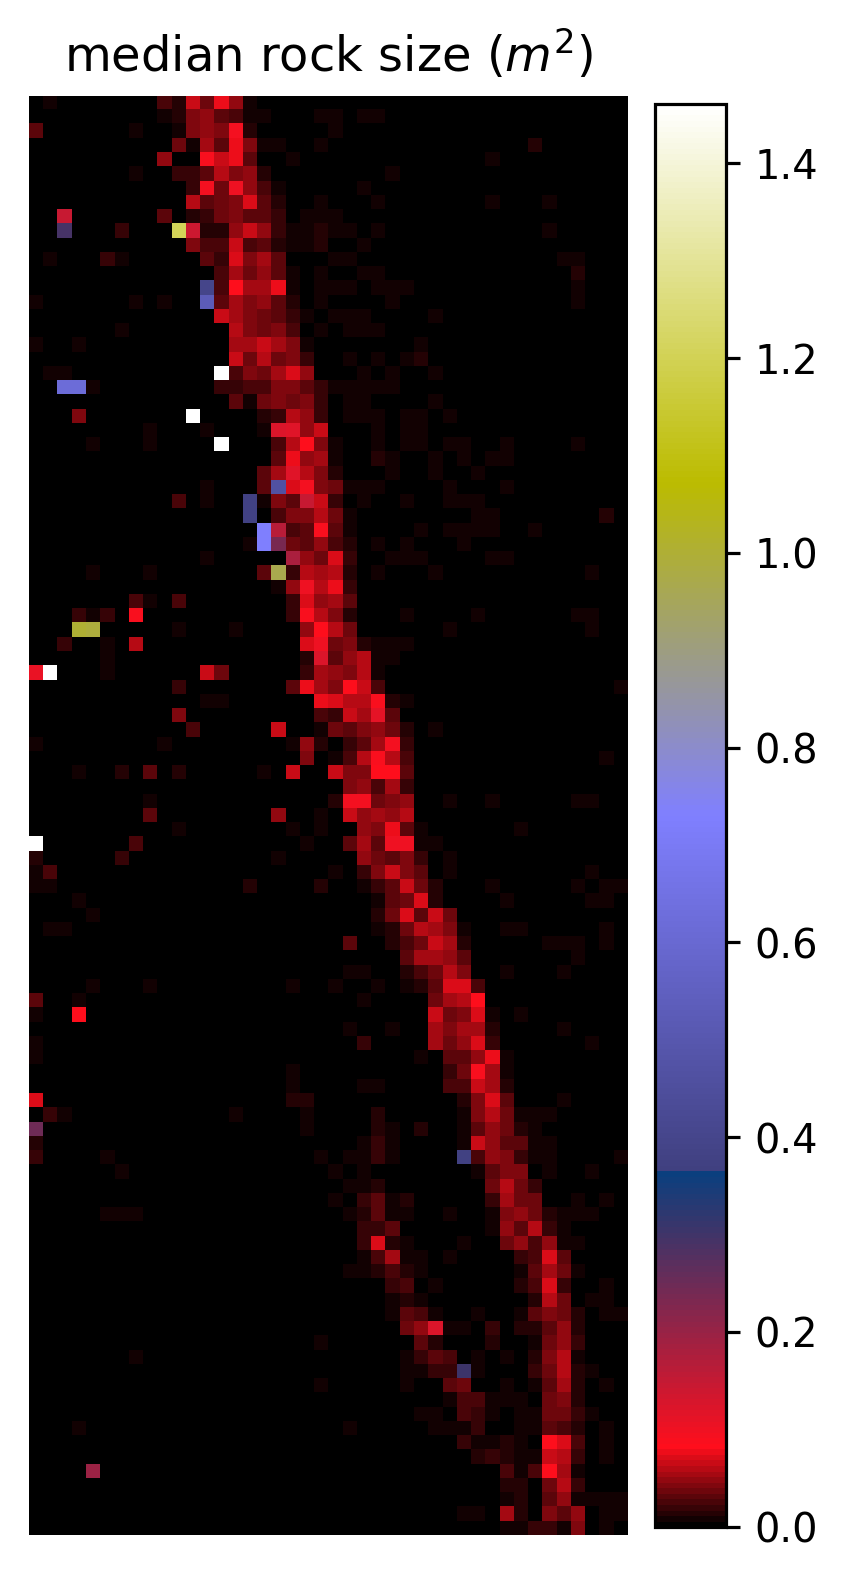

<Figure size 1800x1200 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


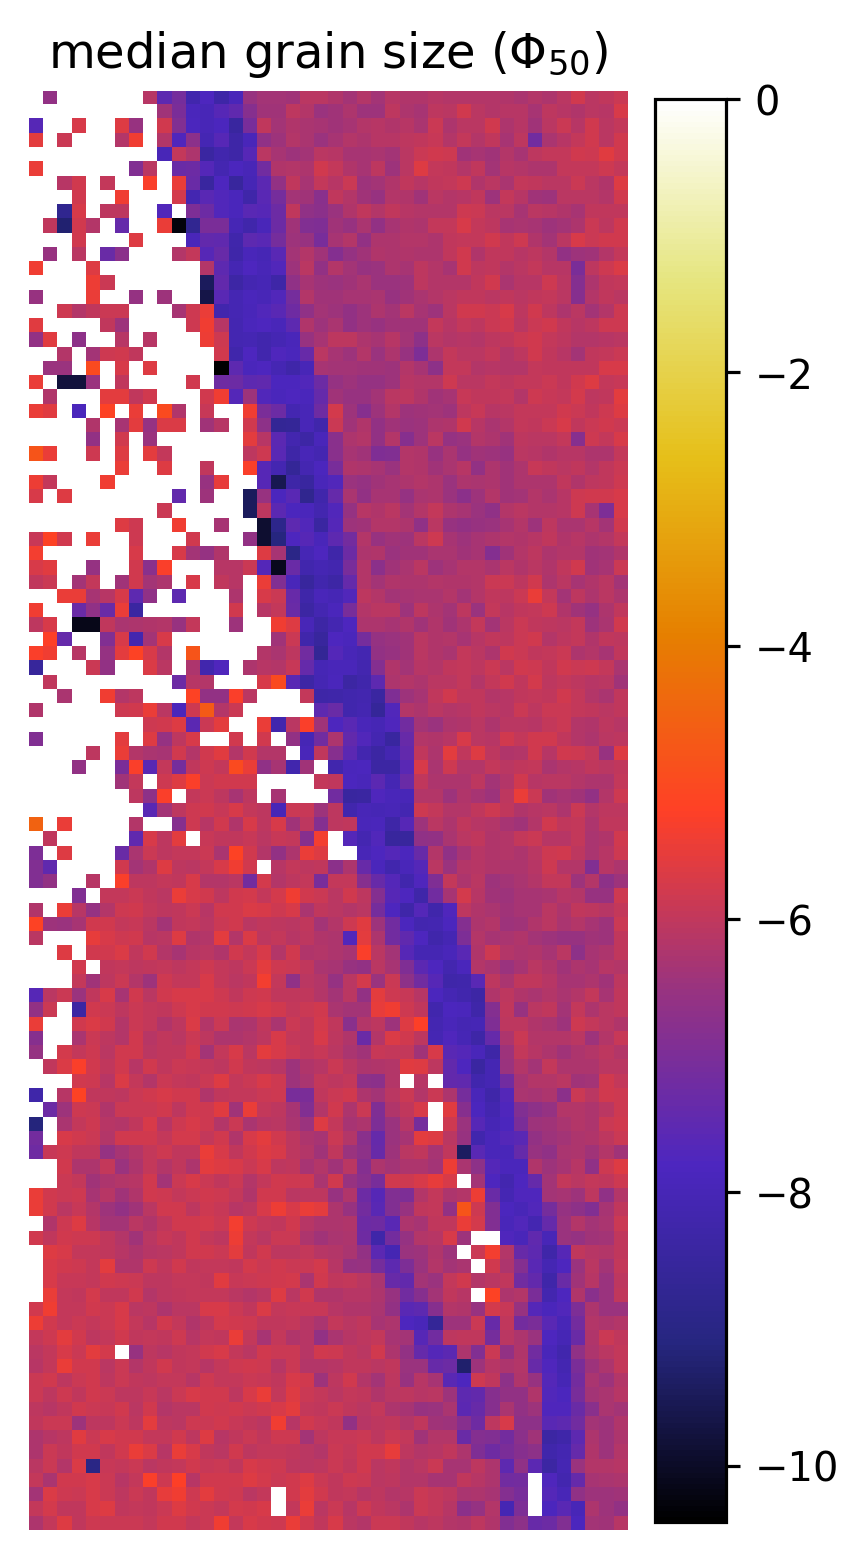

In [20]:
def get_area(shp_dict):
  median_area_map = np.zeros((nm_long, nm_lat))
  for k in shp_dict.keys():
    shp = shape_dict[k]
    areas = shp.area
    areas = areas[areas>0.000314]
    median_area_map[k[0], k[1]] = areas.median()
  return median_area_map


def get_area_phi(shp_dict):
  median_area_map = np.zeros((nm_long, nm_lat))
  for k in shp_dict.keys():
    shp = shape_dict[k]
    areas = shp.area
    areas = areas[areas>0.000314]
    areas = np.median(areas.to_numpy())
    D_mm = np.sqrt(areas * 10**6/pi)*2
    #if D_mm == 0:
    #  D_mm = 1./1e5
    phi = -np.log2(D_mm)
    median_area_map[k[0], k[1]] = phi
  return median_area_map

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 10})


mm = 0.0393701  # 1 mm = 0.0393701 inch

median_area_map = get_area(shape_dict)
fig = plt.figure(figsize = (6.25/2, 11.25), dpi=96*3)
img = plt.imshow(np.flipud(median_area_map.transpose()), cmap='gist_stern')  # cmap: gnuplot, terrain, gist_ncar
#plt.colorbar(img, label="median size", fraction=0.102, pad=0.04)
plt.colorbar(img, fraction=0.102, pad=0.04)
plt.axis('off')
plt.title('median rock size ($m^2$)')
plt.figure(dpi=300)
fig.savefig('paper_figures/median_grain_area.jpg', bbox_inches='tight')
plt.show()


median_area_map_phi = get_area_phi(shape_dict)
fig = plt.figure(figsize = (6.25/2, 11.25), dpi=96*3)
img = plt.imshow(np.flipud(median_area_map_phi.transpose()), cmap='CMRmap')  # cmap: gnuplot, terrain, gist_ncar, CMRmap
plt.colorbar(img, fraction=0.102, pad=0.04)
plt.axis('off')
plt.title('median grain size ($\Phi_{50}$)')
fig.savefig('paper_figures/median_grain_size.jpg', bbox_inches='tight')
plt.show()

## align fault scarp middle line

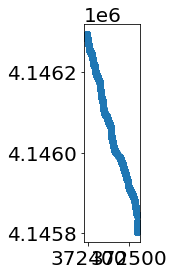

In [17]:
# read shapefile

sk_shape = gpd.read_file("skeleton/skeleton_Point.shp")
sk_shape.plot()

In [ ]:
# only run this cell at first time


# shift all rocks 

shifted_rocks_shape_list = []
for idx_y in range(nm_lat):
  y0 = latitude0 + step*idx_y
  y1 = latitude0 + step*idx_y + step
  box_sk_shape = sk_shape.cx[:, y0:y1]
  if box_sk_shape.geometry.x.to_numpy().shape[0] ==0:
    shift_x = 0
  else:
    mean_x = box_sk_shape.geometry.x.to_numpy().mean()
    shift_x = baseline - mean_x
  shifted_rock_shape = c3_rock_shape.cx[:, y0:y1]
  #print(type(shifted_rock_shape))
  #print(type(shifted_rock_shape['geometry']))
  #print(type(shifted_rock_shape.translate(shift_x, 0)  ))
  shifted_rock_shape['geometry'] = shifted_rock_shape.translate(shift_x, 0)
  shifted_rocks_shape_list.append(shifted_rock_shape)
  print(idx_y, shift_x)

rdf = gpd.GeoDataFrame(pd.concat(shifted_rocks_shape_list, ignore_index=True), crs=shifted_rocks_shape_list[0].crs )
rdf.plot()

In [ ]:
# only run this cell at first time!!
rdf.to_file('c3_rocks/all_v1/shifted_rockPoly_all_v1.shp')

In [22]:
shifted_c3_rock_shape = gpd.read_file("c3_rocks/all_v1/shifted_rockPoly_all_v1.shp")
print(shifted_c3_rock_shape.shape)
areas = shifted_c3_rock_shape.area
shifted_c3_rock_shape = shifted_c3_rock_shape[areas>0.000314]
print(shifted_c3_rock_shape.shape)

(240906, 7)
(233298, 7)


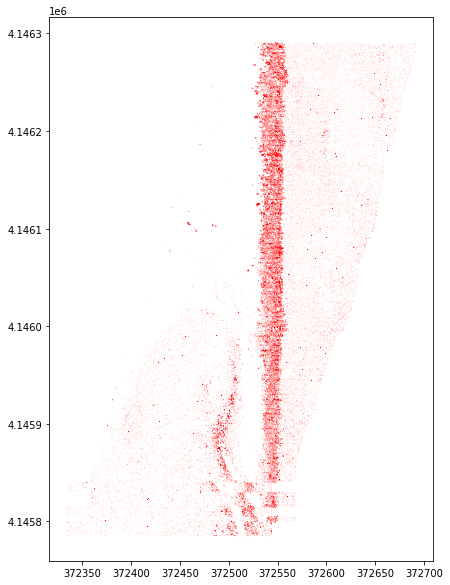

In [23]:
shifted_c3_rock_shape.plot(figsize=(15, 10), color='red')

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(100*mm,290*mm)
ax.axis('OFF')
ax = shifted_c3_rock_shape.plot(ax=ax, color='red')
#fig.savefig("paper_figures/shifted_c3.png", bbox_inches='tight')

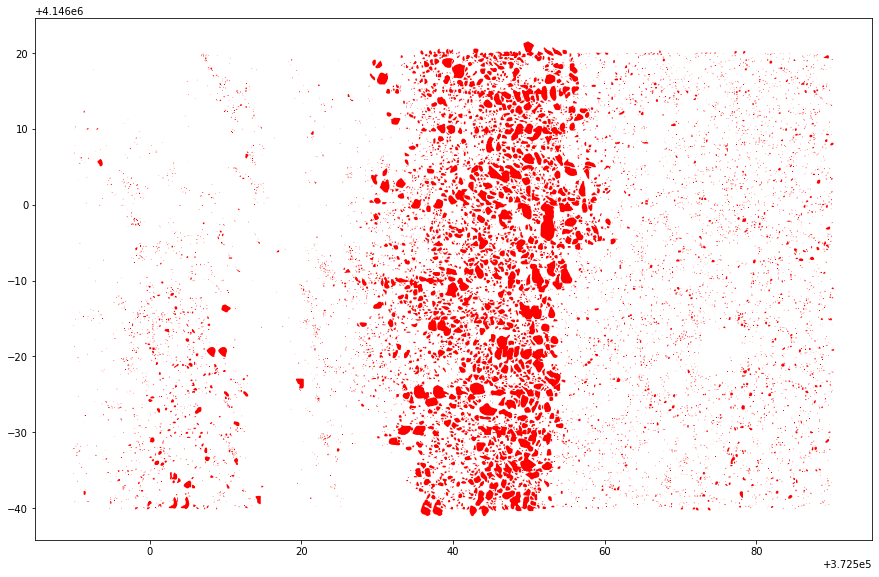

In [24]:
x_left = 372490
x_right = 372590
y_bottom = 4145960
y_top = 4146020

shifted_segment_rock_shape = shifted_c3_rock_shape.cx[x_left:x_right, y_bottom:y_top]
shifted_segment_rock_shape.plot(figsize=(15, 10), color='red')

In [28]:
x_middle = (x_left + x_right)/2
west_shape = shifted_segment_rock_shape.cx[x_middle-20:x_middle,:]
east_shape = shifted_segment_rock_shape.cx[x_middle:x_middle+20,:]

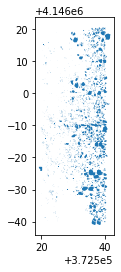

In [29]:
west_shape.plot()

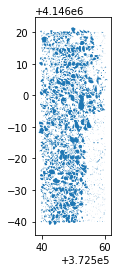

In [30]:
east_sbhape.plot()

-6.779086146327741
-7.615298819530464


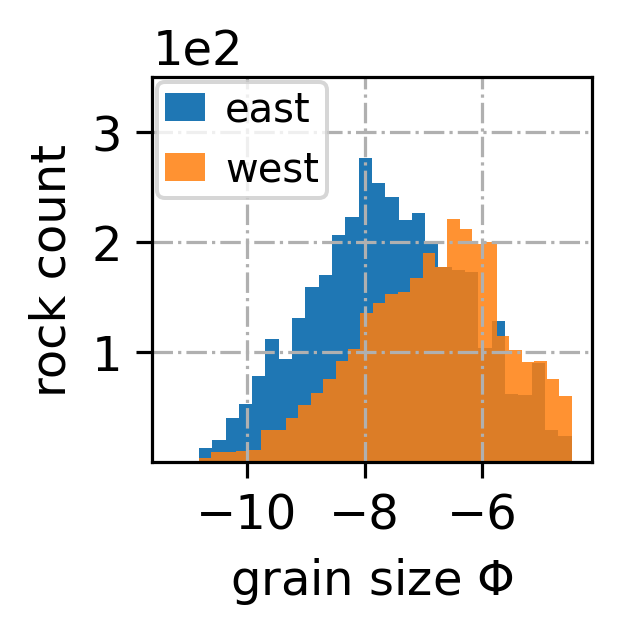

In [115]:
areas = west_shape.area
areas = areas.to_numpy()
areas = areas[areas>0]
D_mm = np.sqrt(areas * 10**6/pi)*2
phi = -np.log2(D_mm)
print(np.median(phi))

areas = east_shape.area
areas = areas.to_numpy()
areas = areas[areas>0]
D_mm = np.sqrt(areas * 10**6/pi)*2
Phi = -np.log2(D_mm)
print(np.median(Phi))


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})

size = (2.15, 2.2)
dpi = 96*3
fig = plt.figure(figsize = size, dpi=dpi)
plt.ylabel('rock count')
plt.xlabel('grain size $\Phi$')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.ylim(0, 350)
#plt.xlim(-13, -2)


plt.xticks(np.arange(-10, -4, 2.0))
plt.yticks(np.arange(100, 301, 100))

plt.hist(Phi[Phi<5], bins=30, label='east')
plt.hist(phi[phi<5], bins=30, alpha = 0.85, label='west')
plt.tick_params(direction="out", length=4)
plt.grid(linestyle='-.')
plt.legend(loc='upper left', fontsize=10, bbox_to_anchor=(-0.035, 1.04), framealpha=0.8, handlelength=1, handletextpad=0.5, borderpad=0.2)

set_size(fig, size, dpi=dpi)
#plt.savefig('paper_figures/f6_0.svg', format='svg')
plt.show()

In [92]:
# slice the area with columns

s = 5  # column width, or step size is 5 meters
column_nm = int((x_right - x_left) / s)
print("The number of columns: ", column_nm)

column_rock_shape_list = []
for column_i in range(column_nm):
  x0 = x_left + column_i * s
  x1 = x_left + (column_i + 1) * s
  column_rock_shape = shifted_segment_rock_shape.cx[x0:x1, :]
  column_rock_shape_list.append(column_rock_shape)

The number of columns:  20


In [93]:
areas = shifted_segment_rock_shape.area.to_numpy()
areas = areas[areas != 0]
D_mm = np.sqrt(areas * 10**6/pi)*2
phi = -np.log2(D_mm)
N = phi.min()
M = phi.max()
print(N, M)

def get_phi_hist_for_column(column_i, bins=10):
  areas = column_rock_shape_list[column_i].area.to_numpy()
  areas = areas[areas != 0]
  D_mm = np.sqrt(areas * 10**6/pi)*2
  phi = -np.log2(D_mm)
  return np.histogram(phi, bins=bins, range=[N, M])

-11.26665187650354 -4.486604882934668


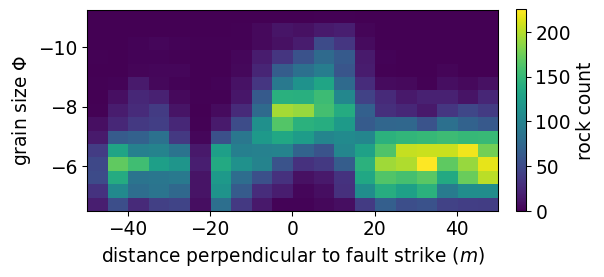

<Figure size 1800x1200 with 0 Axes>

In [101]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 14})

bins = 15
phi_map = np.zeros((bins, column_nm))
for column_i in range(column_nm):
  freq, values = get_phi_hist_for_column(column_i, bins)
  phi_map[:, column_i] = freq

plt.figure(figsize = (150*mm,350*mm), dpi=96)
img = plt.imshow(phi_map,extent=[-50, 50, values[-1], values[0]], aspect=7.2)
plt.colorbar(img, label="rock count", fraction=0.023, pad=0.04)
plt.xlabel('distance perpendicular to fault strike ($m$)')
plt.ylabel('grain size $\Phi$')
#plt.title('rock size distribution across fault scarp')
plt.figure(dpi=300)
plt.show() 

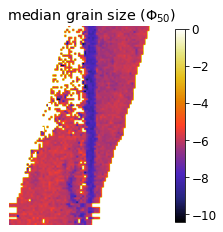

<Figure size 1800x1200 with 0 Axes>

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 12})

plt.figure(figsize = (80*mm,290*mm))
img = plt.imshow(np.flipud(aligned_mean_area_map.transpose()), cmap='CMRmap')  # cmap: gnuplot, terrain, gist_ncar, CMRmap
plt.colorbar(img, fraction=0.055, pad=0.002)
plt.title('median grain size ($\Phi_{50}$)')
plt.axis('OFF')
plt.figure(dpi=300)
plt.show()